In [1]:
using Turing 
using ReverseDiff
using TorusEvol
using StatsPlots
Turing.setadbackend(:reversediff)
Turing.setrdcache(true)
#Turing.setadbackend(:forwarddiff)
Turing.setprogress!(true)

@model function bisection_sampler_vec(p, descs, t)
    n = size(y, 2)
    D = length(descs)
    descs[1] ~ filldist(statdist(p), n)
    
    x = Matrix{Real}(undef, length(p), n)
    for i ∈ 1:n
        x[:, i] ~ transdist(p, t, vec(descs[1][:, i]))
        for d ∈ 2:D
            descs[d][:, i] ~ transdist(p, t, vec(x[:, i]))
        end
    end
end

@model function bisection_sampler(p, y, z, t)
    y ~ statdist(p)
    x ~ transdist(p, t, y)
    z ~ transdist(p, t, x)
end

[ Info: Precompiling TorusEvol [4b860a26-b3bc-4b38-a9ed-83c1dc5d19b0]
[ Info: [Turing]: progress logging is enabled globally
[ Info: [AdvancedVI]: global PROGRESS is set as true


bisection_sampler (generic function with 2 methods)

In [35]:
p = WrappedDiffusion(0.0, 0.0, 0.7, 0.7, 1.0, 1.0, 0.2)
t = 0.2
n = 10
x = rand(statdist(p), n)
x .= rand(statdist(p))

y = rand(transdist(p, t, x[:, 1]), n)
y .= rand(transdist(p, t, x[:, 1]))
z = rand(transdist(p, t, x[:, 1]), n)
z .= rand(transdist(p, t, x[:, 1]))
display(x[:, 1])
display(z[:, 1])
display(y[:, 1])

2-element Vector{Float64}:
 -0.3164721674812396
 -0.11429527718287218

2-element Vector{Float64}:
 -0.40230798964415465
  0.01830414131943109

2-element Vector{Float64}:
 -0.22642872278950574
 -0.21486153543141173

In [38]:
model = bisection_sampler_vec(p, [y, z], t)
chn = sample(model, HMC(0.02, 10, :x), 100)
mean_x = reshape([mean(get(chn, :x).x[i]) for i ∈ 1:(2*n)], 2, :)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


2×10 Matrix{Float64}:
 -0.309152   -0.274547   -0.308385   …  -0.319907   -0.325959  -0.3351
 -0.0753017  -0.0848079  -0.0927303     -0.0707995  -0.088182  -0.0988779

In [84]:
p = WrappedDiffusion(0.0, 0.0, 0.7, 0.7, 1.0, 1.0, 0.2)
t = 0.1
n=4
x = rand(statdist(p), n)
ts = Vector{Any}(undef, n); transdist!(ts, p, t, x)
D = 2
descs = Vector{Any}(undef, D)
for d ∈ 1:D
    descs[d] = hcat(rand.(ts)...)
    print("descendant $d")
    display(descs[d])
end

print("ancestor")
display(x)

num_samples = 1000
burn_in = 500
model = bisection_sampler_vec(p, [y, z, w], t)
chn = sample(model, HMC(0.02, 10, :x), 10)
print("random predicted ancestor sample")
pred_x = reshape([get(chn, :x).x[i][end] for i ∈ 1:(2*n)], 2, :)
display(pred_x)

print("mean predicted ancestor")

mean_x = reshape([mean(get(chn, :x).x[i]) for i ∈ 1:(2*n)], 2, :)

descendant 1

2×4 Matrix{Float64}:
 -0.947801  -0.495727  0.474994   0.19998
 -0.631667   0.251744  0.446483  -0.346217

descendant 2

2×4 Matrix{Float64}:
 -0.732319  -0.424303  0.597122  -0.0477892
 -0.996242   0.364368  0.239246  -0.330375

ancestor

2×4 Matrix{Float64}:
 -0.555018  -0.395434  0.541713   0.0643251
 -0.734777   0.384247  0.332546  -0.337832

LoadError: UndefVarError: `w` not defined

In [73]:
# continuous!!

num=10
p = WrappedDiffusion(-3.0, 3.0, 0.7, 0.7, 1.0, 1.0, 0.2)
x = [0.6, -0.9]
t = 0.3
y = rand(transdist(p, t, x))
z = rand(transdist(p, t, x))



2-element Vector{Float64}:
 -0.07951276147407083
 -0.5119308722775398

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


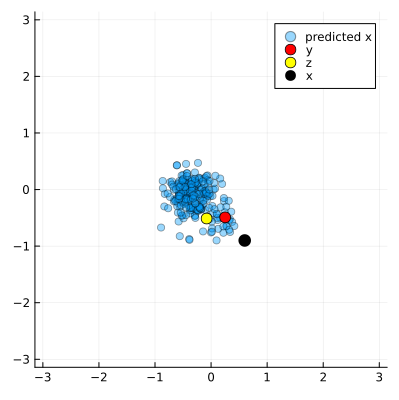

In [78]:
model = bisection_sampler(p, y, z, t)
ch = sample(model, HMC(0.06, 10, :x), 300)
plot(ch, fontfamily="JuliaMono")
pl = scatter(get(ch, :x).x[1][50:300], get(ch, :x).x[2][50:300], xlims=(-π, π), ylims=(-π, π), label="predicted x", alpha=0.4, size=(400,400))
scatter!(pl, [y[1]], [y[2]], mc="red", label="y", ms=6)
scatter!(pl, [z[1]], [z[2]], mc="yellow", label="z", ms=6)
scatter!(pl, [x[1]], [x[2]], mc="black", label="x", ms=7)

[ Info: 10
[ Info: 10
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


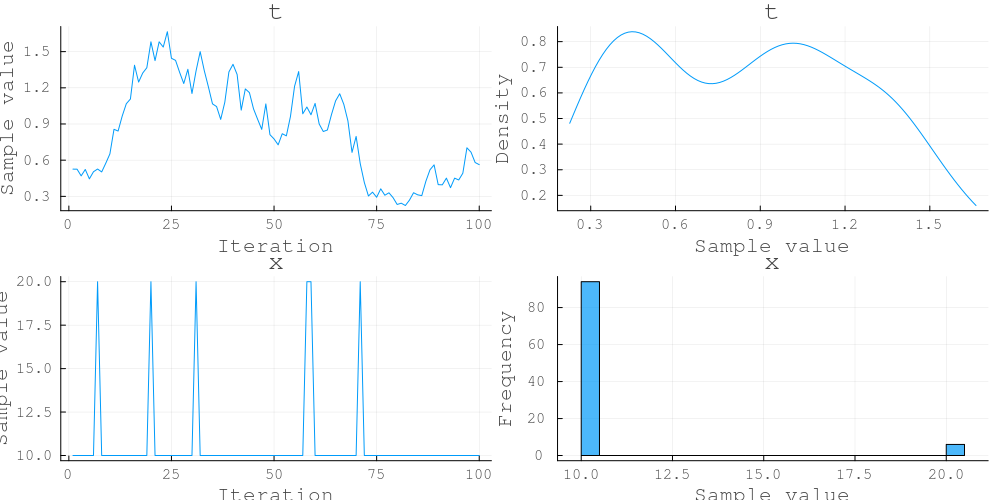

In [26]:
# discrete!!

x = 10
p = WAG_SubstitutionProcess
t = 0.2

y = rand(transdist(p, t/2, x))
@info y

z = rand(transdist(p, t/2, x))
@info z

model = bisection_sampler(p, y, z)
ch = sample(model, Gibbs(HMC(0.03, 5, :t), PG(100, :x)), 100)
plot(ch, fontfamily="JuliaMono")